In [1]:
import os, tf2onnx, keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from keras.layers import Conv1D, MaxPool1D, Dense, LSTM, Input, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import plot_model
from matplotlib.lines import lineStyles
from dtaidistance import dtw_visualisation as dtwvis

from utils.crane_dataset import CraneDataset
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import AdaBoostRegressor
from keras.wrappers.scikit_learn import KerasRegressor
from dtaidistance import dtw
from tqdm.auto import tqdm

In [2]:
train_data_file_path_list = ['safe-boom-40-swing-180-load-40-.csv', 'safe-boom-60-swing-180-load-60-.csv',
                             'safe-boom-70-swing-180-load-100-.csv', 'safe-boom-80-swing-180-load-120-.csv',
                             'unsafe-swing-0-load-70-.csv', 'unsafe-swing-0-load-90-.csv',
                             'unsafe-swing-45-load-70-.csv', 'unsafe-swing-90-load-90-.csv',
                             'unsafe-swing-135-load-50-.csv', 'unsafe-swing-135-load-70-.csv',
                             'unsafe-swing-180-load-70-.csv', 'unsafe-swing-180-load-90-.csv']

# train_data_file_path_list = ['unsafe-swing-0-load-70-.csv', 'unsafe-swing-0-load-90-.csv',
#                              'unsafe-swing-45-load-50-.csv', 'unsafe-swing-45-load-70-.csv',
#                              'unsafe-swing-90-load-70-.csv', 'unsafe-swing-90-load-90-.csv',
#                              'unsafe-swing-135-load-50-.csv', 'unsafe-swing-135-load-70-.csv']
# 
for i, file_path in enumerate(train_data_file_path_list):
    train_data_file_path_list[i] = os.path.join('data', file_path)

In [3]:
val_data_file_path_list = ['safe-boom-50-swing-180-load-50-.csv', 'unsafe-swing-45-load-50-.csv', 'unsafe-swing-90-load-70-.csv',]
# val_data_file_path_list = ['unsafe-swing-180-load-70-.csv', 'unsafe-swing-180-load-90-.csv']

for i, file_path in enumerate(val_data_file_path_list):
    val_data_file_path_list[i] = os.path.join('data', file_path)

#### load dataset

In [4]:
train_dataset_inst = CraneDataset(train_data_file_path_list)
val_dataset_inst = CraneDataset(val_data_file_path_list)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
raw_train_dataset = train_dataset_inst.get_dataset()
raw_val_dataset = val_dataset_inst.get_dataset()

In [6]:
for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    train_data = raw_train_dataset[file_name][train_dataset_inst.get_data_feature_names()+train_dataset_inst.get_data_target_names()]
    train_data = train_data.to_numpy()
    raw_train_dataset[file_name] = train_data[::10]

In [7]:
for file_path in val_data_file_path_list:
    file_name = os.path.basename(file_path)
    val_data = raw_val_dataset[file_name][val_dataset_inst.get_data_feature_names()+val_dataset_inst.get_data_target_names()]
    val_data = val_data.to_numpy()
    raw_val_dataset[file_name] = val_data[::10]

#### display for raw data(train, validation)

Text(0, 0.5, 'value')

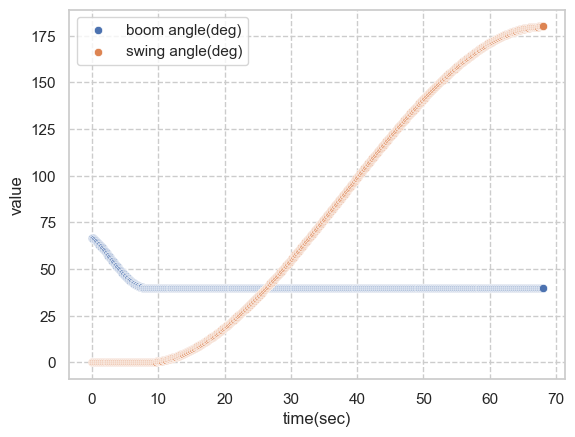

In [8]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (raw_train_dataset[file_name].shape[file_name_index])*0.1, 0.1)

sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(x=time_arr, y=raw_train_dataset[file_name][:, 0], label='boom angle(deg)')
sns.scatterplot(x=time_arr, y=raw_train_dataset[file_name][:, 1], label='swing angle(deg)')

plt.grid(True)
plt.xlabel('time(sec)')
plt.ylabel('value')

Text(0, 0.5, 'Load(N)')

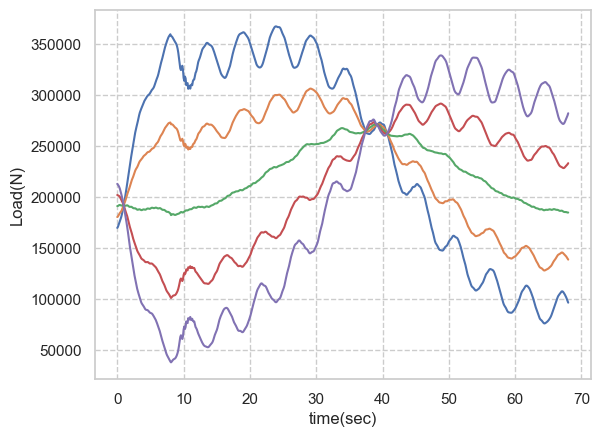

In [9]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (raw_train_dataset[file_name].shape[file_name_index])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

for i in range(5):
    sns.lineplot(x=time_arr, y=raw_train_dataset[file_name][:, 3+i]) 

plt.xlabel('time(sec)')
plt.ylabel('Load(N)')

Text(0, 0.5, 'Load(N)')

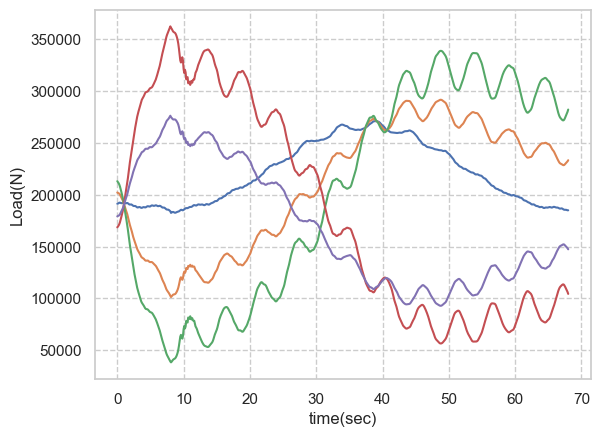

In [10]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (raw_train_dataset[file_name].shape[file_name_index])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

for i in range(5):
    sns.lineplot(x=time_arr, y=raw_train_dataset[file_name][:, 5+i]) 

plt.xlabel('time(sec)')
plt.ylabel('Load(N)')

Text(0.5, 0, 'angle(deg)')

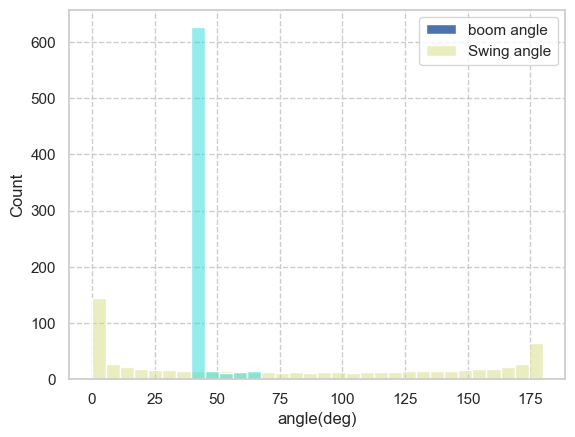

In [11]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
sns.histplot(raw_train_dataset[file_name][:, 0:2], palette='rainbow')
plt.legend(['boom angle', 'Swing angle'])
#plt.xlim(-100, 200)
plt.xlabel('angle(deg)')

Text(0.5, 0, 'Load(N)')

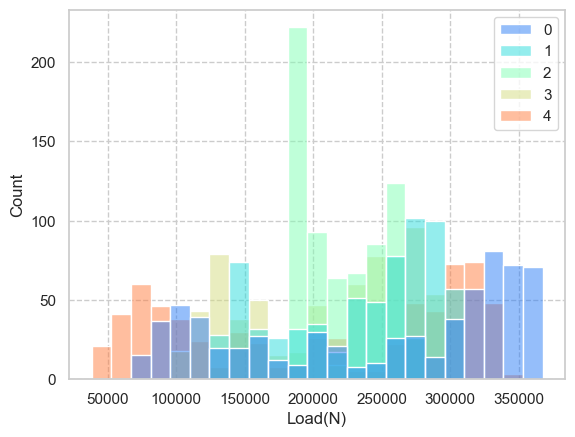

In [12]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(raw_train_dataset[file_name][:, 3:8], palette='rainbow')
plt.xlabel('Load(N)')

Text(0.5, 0, 'Load(N)')

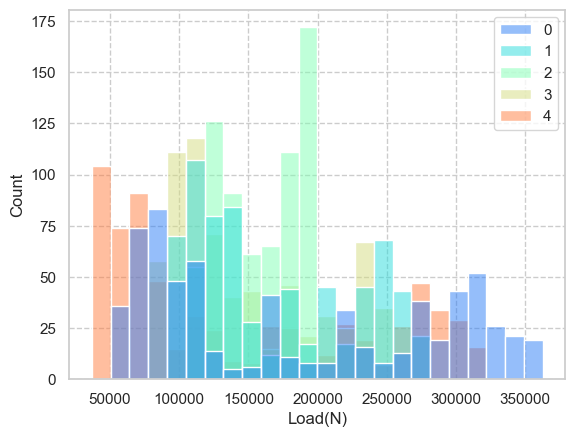

In [13]:
#plt.xlim(-100, 200)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(raw_train_dataset[file_name][:, 8:13], palette='rainbow')
plt.xlabel('Load(N)')

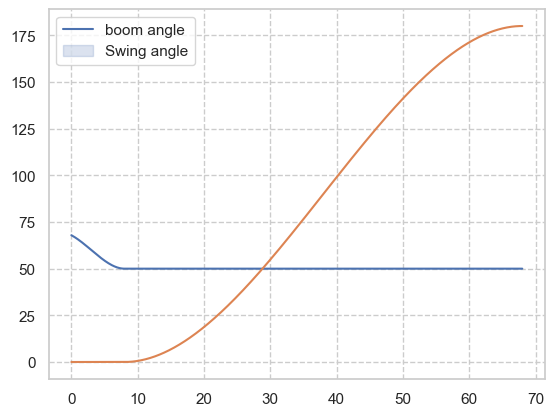

In [14]:
file_name_index = 0
file_name = os.path.basename(val_data_file_path_list[file_name_index])
time_arr = np.arange(0, (raw_val_dataset[file_name].shape[file_name_index])*0.1, 0.1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

for i in range(2):
    sns.lineplot(x=time_arr, y=raw_val_dataset[file_name][:, i])

plt.legend(['boom angle', 'Swing angle'])

Text(0.5, 0, 'Load(N)')

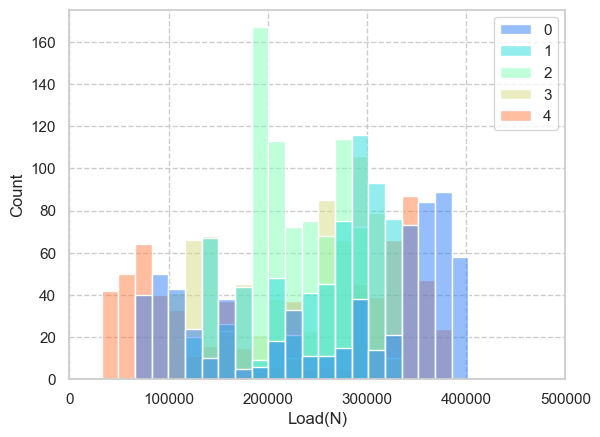

In [15]:
file_name_index = 0
file_name = os.path.basename(val_data_file_path_list[file_name_index])

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(raw_val_dataset[file_name][:, 3:8], palette='rainbow')
plt.xlim(0, 500000)
plt.xlabel('Load(N)')

Text(0.5, 0, 'Load(N)')

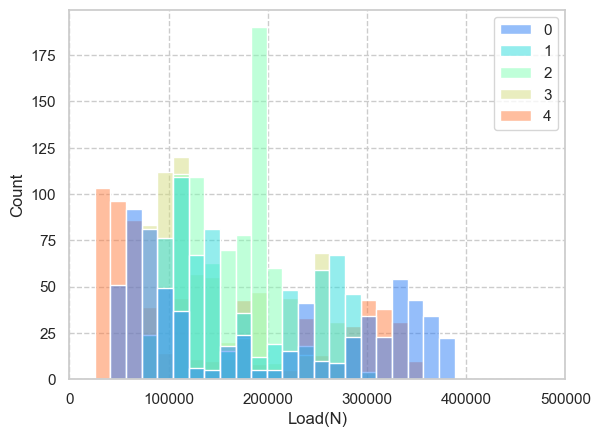

In [16]:
file_name_index = 0
file_name = os.path.basename(val_data_file_path_list[file_name_index])

sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(raw_val_dataset[file_name][:, 8:13], palette='rainbow')
plt.xlim(0, 500000)
plt.xlabel('Load(N)')

#### execute feature engineering

In [17]:
new_train_dataset = dict()

for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    new_train_dataset[file_name] = np.copy(raw_train_dataset[file_name])
    
    train_grad_boom_angle = np.gradient(new_train_dataset[file_name][:, 0])
    train_grad_swing_angle = np.gradient(new_train_dataset[file_name][:, 1])
    
    train_grad_load_list = []
    
    for i in range(10):
        train_grad_load_list.append(np.gradient(new_train_dataset[file_name][:, 3+i]))
    
    train_grad_angle = np.stack([train_grad_boom_angle, train_grad_swing_angle], axis=1)
    train_grad_load = np.array(train_grad_load_list).T

    new_train_dataset[file_name] = np.hstack([new_train_dataset[file_name][:, 0:3], train_grad_angle, train_grad_load, new_train_dataset[file_name][:, 3:13]]) 

# new data columns: 0:boom angle, 1:swing angle, 2:operation load, 3:grad_boom_angle, 4:grad_swing_angle, 5~14:grad_load(10ea), 15~24: ground load(10ea) 

In [18]:
new_val_dataset = dict()

for file_path in val_data_file_path_list:
    file_name = os.path.basename(file_path)
    new_val_dataset[file_name] = np.copy(raw_val_dataset[file_name])
    
    val_grad_boom_angle = np.gradient(new_val_dataset[file_name][:, 0])
    val_grad_swing_angle = np.gradient(new_val_dataset[file_name][:, 1])
    
    val_grad_load_list = []
    
    for i in range(10):
        val_grad_load_list.append(np.gradient(new_val_dataset[file_name][:, 3+i]))
    
    val_grad_angle = np.stack([val_grad_boom_angle, val_grad_swing_angle], axis=1)
    val_grad_load = np.array(val_grad_load_list).T

    new_val_dataset[file_name] = np.hstack([new_val_dataset[file_name][:, 0:3], val_grad_angle, val_grad_load, new_val_dataset[file_name][:, 3:13]]) 

<AxesSubplot:>

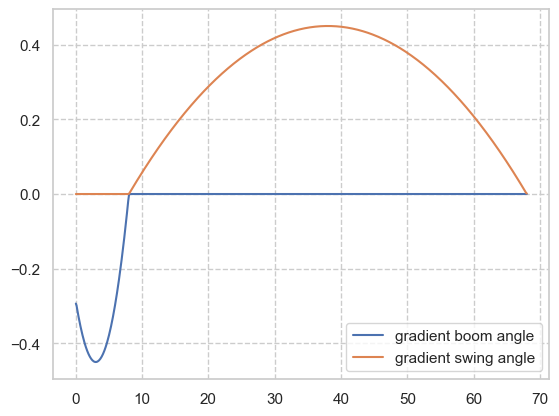

In [19]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_train_dataset[file_name].shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})
#sns.scatterplot(x=time_arr, y=new_train_dataset[file_name][:, 0], label='boom angle')
sns.lineplot(x=time_arr, y=new_train_dataset[file_name][:, 3], label='gradient boom angle')
sns.lineplot(x=time_arr, y=new_train_dataset[file_name][:, 4], label='gradient swing angle')
#plt.ylim(-3, 3)

(-1.0, 1.0)

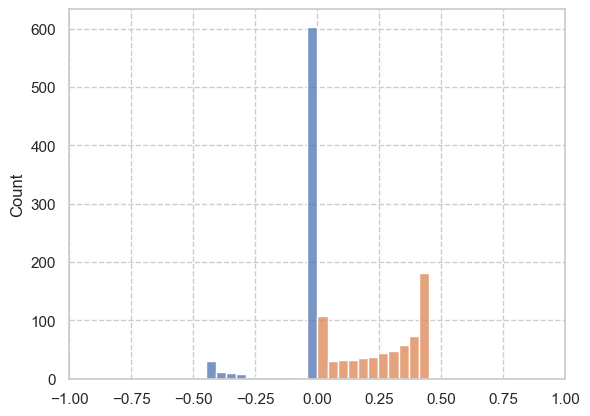

In [20]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.histplot(new_train_dataset[file_name][:, 3], label='gradient boom angle')
sns.histplot(new_train_dataset[file_name][:, 4], label='gradient swing angle')
plt.xlim(-1, 1)


<AxesSubplot:>

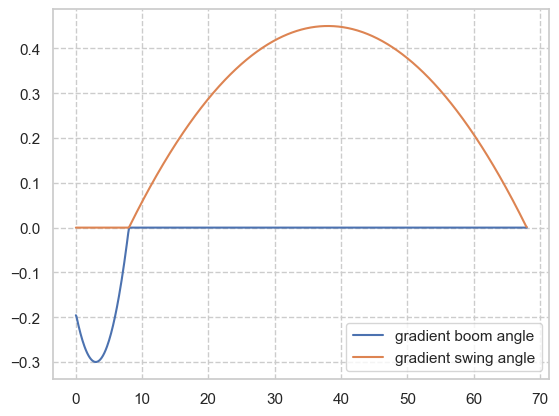

In [21]:
file_name_index = 0
file_name = os.path.basename(val_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_val_dataset[file_name].shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})
#sns.scatterplot(x=time_arr, y=new_train_dataset[file_name][:, 0], label='boom angle')
sns.lineplot(x=time_arr, y=new_val_dataset[file_name][:, 3], label='gradient boom angle')
sns.lineplot(x=time_arr, y=new_val_dataset[file_name][:, 4], label='gradient swing angle')

(-6000.0, 6000.0)

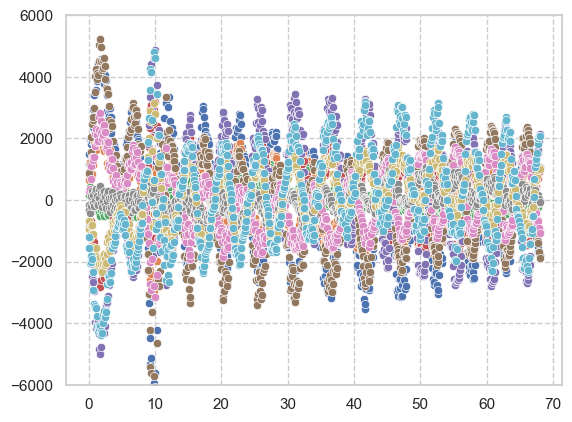

In [22]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_train_dataset[file_name].shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

for i in range(10):
    sns.scatterplot(x=time_arr, y=new_train_dataset[file_name][:, 5+i])

plt.ylim(-6000, 6000)

(-6000.0, 6000.0)

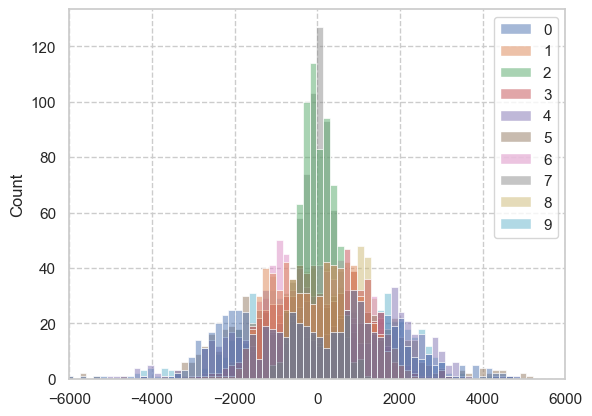

In [23]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_train_dataset[file_name].shape[0])*0.1, 0.1)

sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.histplot(new_train_dataset[file_name][:, 5:15])
plt.xlim(-6000, 6000)

#### data merge from feature extraction

In [24]:
arr_list = []

for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    arr_list.append(new_train_dataset[file_name])

new_train_total_data = np.vstack(arr_list)

In [25]:
scaler = RobustScaler().fit(new_train_total_data)

In [26]:
scaled_new_train_dataset = dict()
scaled_new_val_dataset = dict()

for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    scaled_new_train_dataset[file_name] = scaler.transform(new_train_dataset[file_name])

for file_path in val_data_file_path_list:
    file_name = os.path.basename(file_path)
    scaled_new_val_dataset[file_name] = scaler.transform(new_val_dataset[file_name])

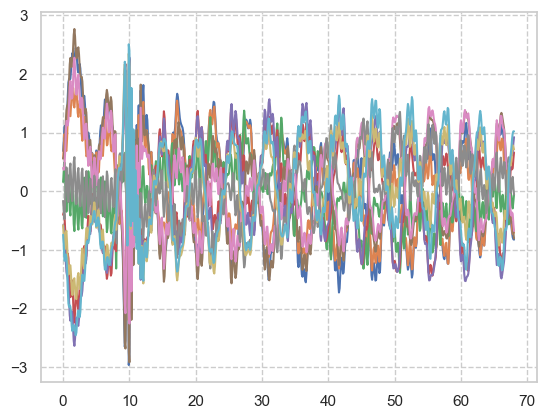

In [27]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (new_train_dataset[file_name].shape[0])*0.1, 0.1)

for i in range(10):
    sns.lineplot(x=time_arr, y=scaled_new_train_dataset[file_name][:, i+5])

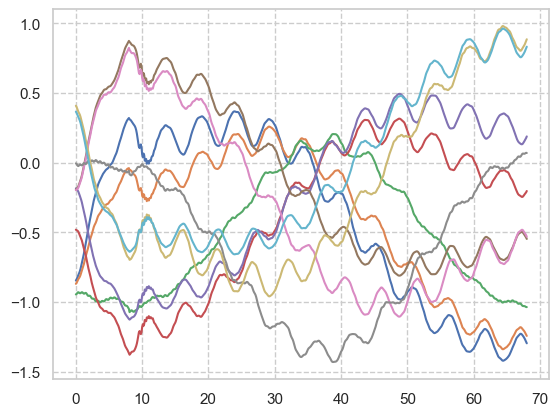

In [28]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])
time_arr = np.arange(0, (scaled_new_train_dataset[file_name].shape[0])*0.1, 0.1)

for i in range(10):
    sns.lineplot(x=time_arr, y=scaled_new_train_dataset[file_name][:, i+15])

<AxesSubplot:ylabel='Count'>

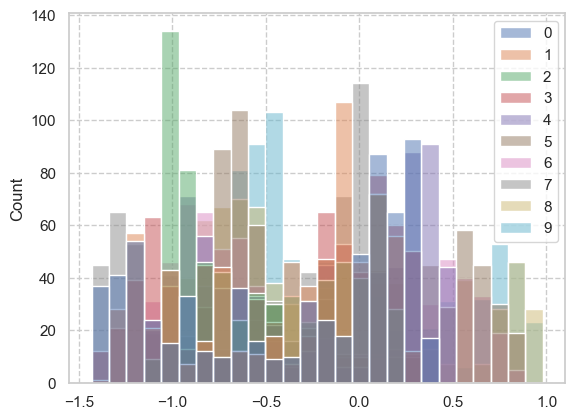

In [29]:
file_name_index = 0
file_name = os.path.basename(train_data_file_path_list[file_name_index])

sns.histplot(scaled_new_train_dataset[file_name][: , 15:])

In [30]:
def create_dataset(data, seq_len=1, pred_distance=1):
    feature, target = [], []
    
    for i in range(data.shape[0] - seq_len - pred_distance -1):
        feature.append(data[i:i+seq_len, 0:15])
        target.append(data[i+seq_len+pred_distance, 15:])
    
    return np.array(feature), np.array(target)

In [31]:
optimizer = Adam(learning_rate=0.0001)

seq_len = 30
pred_distance = 30
n_of_feature = 15
n_of_extra_feature = n_of_feature*2
n_of_output = 10
hidden_size = 500
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
csv_logger = CSVLogger('log.csv', append=True, separator=',')

In [32]:
data_len_list = []

for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    
    data_len_list.append(scaled_new_train_dataset[file_name].shape[0])

batch_size = max(data_len_list)

In [33]:
model_chk_point = ModelCheckpoint(filepath='model.h5', monitor="val_loss", verbose=0, save_best_only=True,
                                  save_weights_only=False, mode="min", save_freq="epoch", initial_value_threshold=None)

In [34]:
def my_lstm(): 
    input_layer = keras.layers.Input(shape=(seq_len, n_of_feature))
    conv_layer = keras.layers.Conv1D(filters=n_of_extra_feature, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(input_layer)
    #conv_layer = MaxPool1D(pool_size=2)(conv_layer)
    #conv_layer = keras.layers.Conv1D(filters=n_of_extra_feature*2, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(conv_layer)
    #conv_layer = MaxPool1D(pool_size=2)(conv_layer)

    lstm_layers = []
    weight_set ={}

    for i in range(n_of_output):
        #lstm_input = keras.layers.MaxPooling1D(pool_size=2)(lstm_input)
        lstm_output = keras.layers.LSTM(units=hidden_size, return_sequences=False, kernel_regularizer=l2(0.01), dropout=0.2, name=f'lstm_{i}')(conv_layer)
        #lstm_output = Dense(1, activation='linear')(lstm_output)
        lstm_layers.append(lstm_output)

    concat =  keras.layers.concatenate(lstm_layers)
    #output_layer = keras.layers.Dropout(0.2)(concat)
    #output_layer = keras.layers.Dense(int(concat.shape[1]), activation='relu')(concat)
    #output_layer = keras.layers.Dropout(0.2)(output_layer)
    #output_layer = keras.layers.Dense(int(output_layer.shape[1]/2), activation='linear')(output_layer)
    #output_layer = keras.layers.Dropout(0.2)(output_layer)
    #output_layer = keras.layers.Dense(int(output_layer.shape[1]/2), activation='linear')(output_layer)
    #output_layer = keras.layers.Dropout(0.2)(output_layer)
    #output_layer = keras.layers.Dense(int(output_layer.shape[1]/2), activation='linear')(output_layer)
    #output_layer = keras.layers.Dropout(0.2)(output_layer)
    output_layer = Dense(n_of_output, activation='linear')(concat)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
    return model
     
        

In [35]:
model = my_lstm()

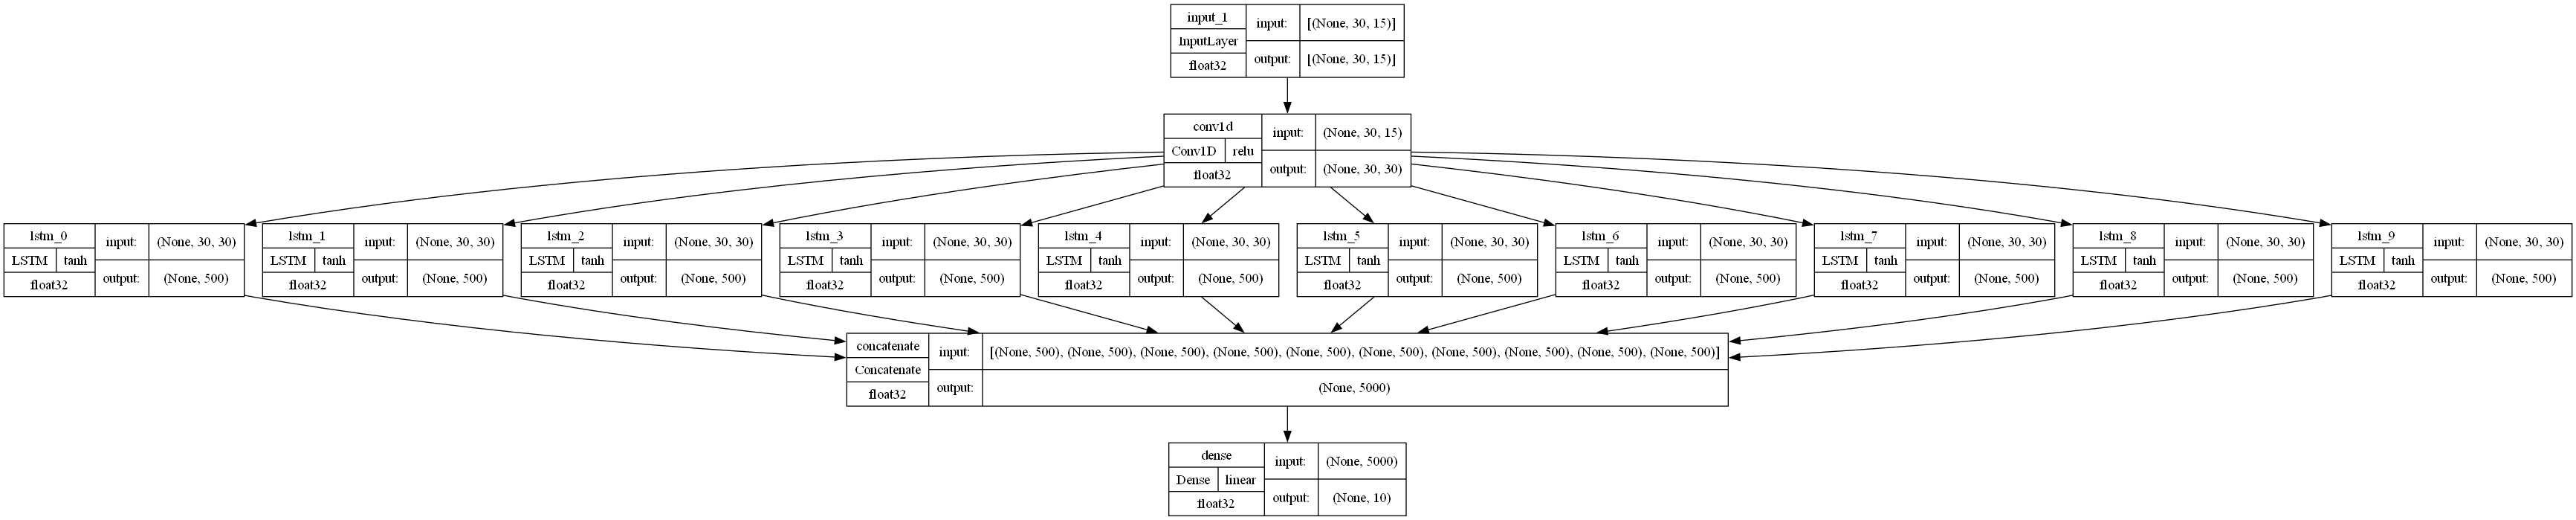

In [36]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

In [37]:
model_history = None
metric_log = []
epoch = 500

with tqdm(total = epoch*len(train_data_file_path_list)*len(val_data_file_path_list)) as pbar:
    for i in range(epoch):
        for file_path in train_data_file_path_list:
            train_file_name = os.path.basename(file_path)
            
            for file_path in val_data_file_path_list:
                val_file_name = os.path.basename(file_path)

                scaled_x_train, scaled_y_train = create_dataset(data=scaled_new_train_dataset[train_file_name], seq_len=seq_len, pred_distance=pred_distance)
                scaled_x_val, scaled_y_val = create_dataset(data=scaled_new_val_dataset[val_file_name], seq_len=seq_len, pred_distance=pred_distance)
                
                model_history= model.fit(x=scaled_x_train, y=scaled_y_train, validation_data=(scaled_x_val, scaled_y_val), epochs=1, batch_size=10000, verbose=0,
                                               callbacks=[early_stop, csv_logger, model_chk_point])
                pbar.update(1)

        train_loss = model_history.history['loss'][0]
        val_loss = model_history.history['val_loss'][0]
        train_abs_error = model_history.history['mean_absolute_error'][0]
        val_abs_error = model_history.history['val_mean_absolute_error'][0]
        
        metric_log.append(np.array([i, train_loss, val_loss, train_abs_error, val_abs_error]))
        
        print(i, train_loss, val_loss, train_abs_error, val_abs_error)

  0%|          | 0/18000 [00:00<?, ?it/s]

0 5.551178932189941 5.547015190124512 0.43852755427360535 0.3601991534233093
1 4.6015191078186035 4.765414714813232 0.3008139431476593 0.3422050178050995
2 3.9362168312072754 4.213485240936279 0.3287641406059265 0.38064828515052795
3 3.3431167602539062 3.6012940406799316 0.2825700342655182 0.36065709590911865
4 2.855499505996704 3.1799888610839844 0.2663167715072632 0.3738441467285156
5 2.442509174346924 2.724440574645996 0.24506597220897675 0.3618387281894684
6 2.1123905181884766 2.447770833969116 0.24912984669208527 0.38693976402282715
7 1.8288686275482178 2.113290309906006 0.2426891326904297 0.3463982939720154
8 1.5881304740905762 1.9221798181533813 0.24329961836338043 0.34966298937797546
9 1.3968898057937622 1.7360551357269287 0.255378395318985 0.34174859523773193
10 1.232370138168335 1.5686089992523193 0.2537144720554352 0.3328614830970764
11 1.0998077392578125 1.3373796939849854 0.2535058259963989 0.30392125248908997
12 0.9654504060745239 1.2925353050231934 0.23087234795093536 0.

In [38]:
best_model = keras.models.load_model('model.h5')

In [39]:
pred_train_result_list = []
scaled_y_train_list = []

for file_path in train_data_file_path_list:
    file_name = os.path.basename(file_path)
    
    scaled_x_train, scaled_y_train = create_dataset(data=scaled_new_train_dataset[file_name], seq_len=seq_len, pred_distance=pred_distance)
    pred_train_result_list.append(best_model.predict(scaled_x_train))
    scaled_y_train_list.append(scaled_y_train)

pred_train_result_arr = np.vstack(pred_train_result_list)
scaled_y_train_arr = np.vstack(scaled_y_train_list)

pred_val_result_list = []
scaled_y_val_list = []

for file_path in val_data_file_path_list:
    file_name = os.path.basename(file_path)
    
    scaled_x_val, scaled_y_val = create_dataset(data=scaled_new_val_dataset[file_name], seq_len=seq_len, pred_distance=pred_distance)
    pred_val_result_list.append(best_model.predict(scaled_x_val))
    scaled_y_val_list.append(scaled_y_val)
    
pred_val_result_arr = np.vstack(pred_val_result_list)
scaled_y_val_arr = np.vstack(scaled_y_val_list)

9/9 [==============================] - 0s 20ms/step


In [40]:
y_train_pred = scaler.inverse_transform(np.hstack([np.zeros(shape=(pred_train_result_arr.shape[0], n_of_feature)), pred_train_result_arr]))
y_train_pred = y_train_pred[:, 15:]

y_val_pred = scaler.inverse_transform(np.hstack([np.zeros(shape=(pred_val_result_arr.shape[0], n_of_feature)), pred_val_result_arr]))
y_val_pred = y_val_pred[:, 15:]

y_train = scaler.inverse_transform(np.hstack([np.zeros(shape=(pred_train_result_arr.shape[0], n_of_feature)), scaled_y_train_arr]))
y_train = y_train[:, 15:]

y_val = scaler.inverse_transform(np.hstack([np.zeros(shape=(pred_val_result_arr.shape[0], n_of_feature)), scaled_y_val_arr]))
y_val = y_val[:, 15:]

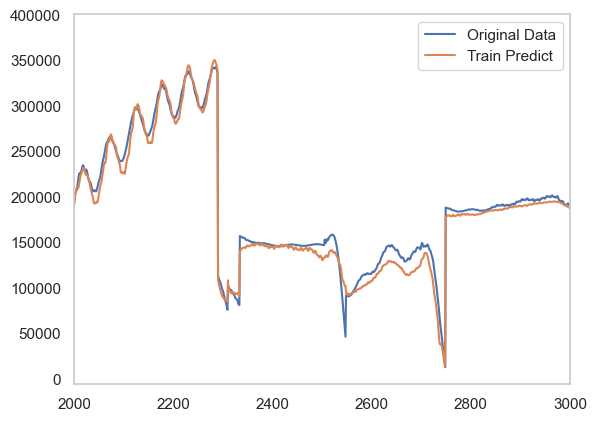

In [41]:
train_load_index = 8
sns.lineplot(y_train[:, train_load_index], label='Original Data')
sns.lineplot(y_train_pred[:, train_load_index], label='Train Predict')
plt.xlim(2000, 3000)
plt.grid()
plt.legend()
plt.show()

In [42]:
print(r2_score(y_train, y_train_pred))
print(mean_absolute_error(y_train, y_train_pred))
print(mean_absolute_percentage_error(y_train, y_train_pred))
print(np.sqrt(mean_squared_error(y_train, y_train_pred)))
#print(dtw.distance(y_train[:, 0], y_train_pred[:, 0]))

0.9788566931214951
8829.986892042372
0.05606116672394864
11907.582256018633


In [45]:
#dtw_path = dtw.warping_path(y_train[:, 0], y_train_pred[:, 0])
#dtwvis.plot_warping(y_train[:, 0], y_train_pred[:, 0], dtw_path)

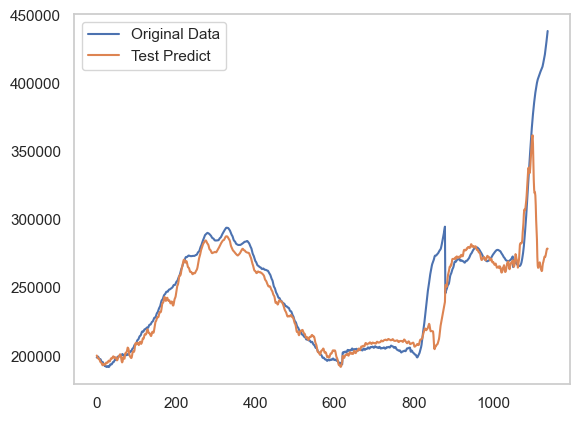

In [63]:
val_load_index = 2
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.lineplot(y_val[:, val_load_index], label='Original Data')
sns.lineplot(y_val_pred[:, val_load_index],  label='Test Predict')
#plt.xlim(0, 500)
plt.grid()
plt.legend()
plt.show()

In [55]:
print(r2_score(y_val, y_val_pred))
print(mean_absolute_error(y_val, y_val_pred))
print(mean_absolute_percentage_error(y_val, y_val_pred))
print(np.sqrt(mean_squared_error(y_val, y_val_pred)))
#print(dtw.distance(y_val[:, 0], y_val_pred[:, 0]))

0.8159353510396155
14048.72345503895
0.14910275449878377
27850.5061319193


In [48]:
#dtw_path = dtw.warping_path(y_val[:, 0], y_val_pred[:, 0])
#dtwvis.plot_warping(y_val[:, 0], y_val_pred[:, 0], dtw_path)

In [58]:
metric_log_arr = np.vstack(metric_log)

<AxesSubplot:xlabel='Epoch', ylabel='Loss'>

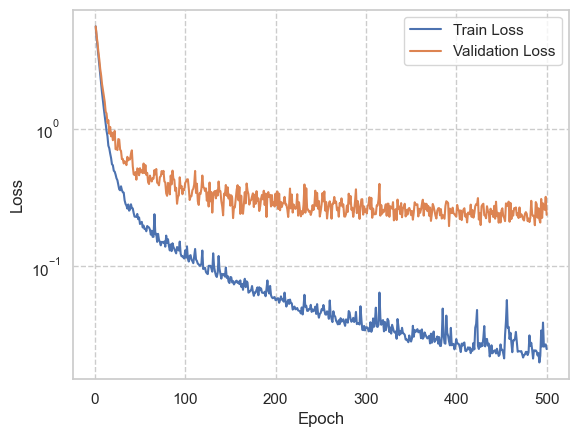

In [60]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

train_loss_arr = metric_log_arr[:, 1]
val_loss_arr = metric_log_arr[:, 2]
epoch_arr = metric_log_arr[:, 0]+1

sns.lineplot(x=epoch_arr, y=train_loss_arr, label='Train Loss')
sns.lineplot(x=epoch_arr, y=val_loss_arr, label='Validation Loss')

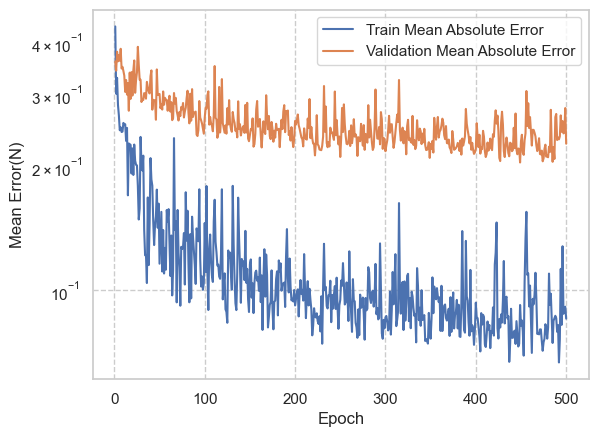

In [61]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.xlabel('Epoch')
plt.ylabel('Mean Error(N)')

epoch_arr = metric_log_arr[:, 0]+1
train_abs_error_arr = metric_log_arr[:, 3]
val_abs_error_arr = metric_log_arr[:, 4]

sns.lineplot(x=epoch_arr, y=train_abs_error_arr, label='Train Mean Absolute Error')
sns.lineplot(x=epoch_arr, y=val_abs_error_arr, label='Validation Mean Absolute Error')
plt.yscale('log')

In [51]:
onnx_model, _ = tf2onnx.convert.from_keras(best_model)

In [52]:
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())